Here we attempt to draw an MST

In [1]:
%reset -sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns

In [2]:
df = pd.read_pickle("../preprocessing/processed_dataframe.pkl")

In [3]:
# Python program for Kruskal's algorithm to find 
# Minimum Spanning Tree of a given connected,  
# undirected and weighted graph 
  
from collections import defaultdict 
  
# Class to represent a graph 
class Graph: 
  
    def __init__(self,vertices): 
        self.V = vertices # No. of vertices 
        self.graph = [] # default dictionary to store graph 
   
    # function to add an edge to graph 
    def addEdge(self,u,v,w): 
        self.graph.append([u,v,w]) 
  
    # A utility function to find set of an element i 
    # (uses path compression technique) 
    def find(self, parent, i): 
        if parent[i] == i: 
            return i 
        return self.find(parent, parent[i]) 
  
    # A function that does union of two sets of x and y 
    # (uses union by rank) 
    def union(self, parent, rank, x, y): 
        xroot = self.find(parent, x) 
        yroot = self.find(parent, y) 
  
        # Attach smaller rank tree under root of  
        # high rank tree (Union by Rank) 
        if rank[xroot] < rank[yroot]: 
            parent[xroot] = yroot 
        elif rank[xroot] > rank[yroot]: 
            parent[yroot] = xroot 
  
        # If ranks are same, then make one as root  
        # and increment its rank by one 
        else : 
            parent[yroot] = xroot 
            rank[xroot] += 1
  
    # The main function to construct MST using Kruskal's algo 
    def KruskalMST(self): 
  
        result = [] # This will store the resultant MST 
  
        i = 0 # An index variable, used for sorted edges 
        e = 0 # An index variable, used for result[] 
  
        # Step 1: Sort all the edges in non-decreasing order 
        # of their weight. If we are not allowed to change 
        # the given graph, we can create a copy of graph 
        self.graph = sorted(self.graph,
                            key=lambda item: item[2]) 
  
        parent = []; rank = [] 
  
        # Create V subsets with single elements 
        for node in range(self.V): 
            parent.append(node) 
            rank.append(0) 
      
        # Number of edges to be taken is equal to V-1 
        while e < self.V -1 : 
  
            # Step 2: Pick the smallest edge and increment the index for next iteration 
            u,v,w =  self.graph[i] 
            i = i + 1
            x = self.find(parent, u) 
            y = self.find(parent ,v) 
  
            # If including this edge does't cause cycle, include 
            # it in result and increment the index of result for next edge 
            if x != y: 
                e = e + 1     
                result.append([u,v,w]) 
                self.union(parent, rank, x, y)             
            # Else discard the edge 
              
        return result

In [4]:
num_cstcs = 1

In [5]:
g = Graph(df.shape[0]+num_cstcs+1) 

for index, row in df.iterrows():
    for adj,mass in zip(row["adjacent"], row["shared_param"]):
        g.addEdge(index, adj, 1/mass)

for index, row in df.iterrows():
    for id_cstc in range(num_cstcs):
        g.addEdge(index, id_cstc+df.shape[0], 10000+1000/np.sqrt((1+row["TOTAL"])))
        g.addEdge(df.shape[0] + num_cstcs, id_cstc+df.shape[0], -9999)
        
result = g.KruskalMST() 

In [6]:
1/mass

180.84965978935423

In [7]:
id_cstc+df.shape[0]

318

In [8]:
df.sample()

,index,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre,adjacent,shared_param
205,208,kml_209,290,NORTHSHORE,PUNGGOL,"[[[103.912995910563, 1.42004440643633, 0.0], [...",103.907065,1.418225,"[262, 300, 208, 287]","[0.013537186847531316, 0.00014377145354706715,..."


In [9]:
new_df = pd.DataFrame(zip(*[np.linspace(103.6,104,num_cstcs), 
                            [1.1]*10]),
                      columns=["x_centre", "y_centre"])
new_df = new_df.append(pd.DataFrame([[103.8,1.0]], columns=["x_centre", "y_centre"]))
new_df

,x_centre,y_centre
0,103.6,1.1
0,103.8,1.0


In [10]:
df_extended = df.append(new_df, sort=False).reset_index()
# df_extended

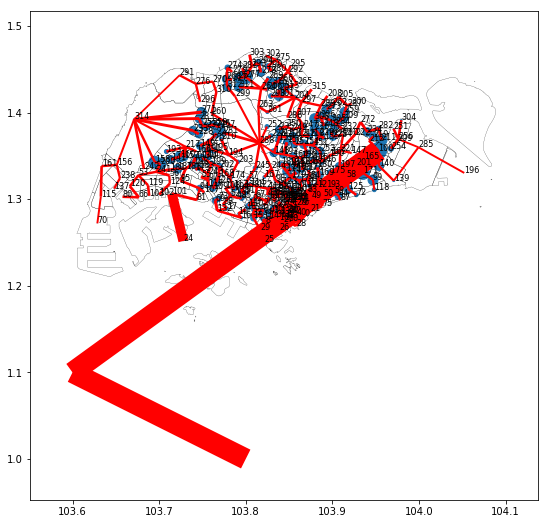

In [11]:
fig, ax = plt.subplots(figsize=(14,9))

# plot population mass
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
for i,(x,y) in enumerate(zip(df["x_centre"], df["y_centre"])):
    plt.text(x,y,i,fontsize=8)
lines = []

# plot subzone boundaries
for i,rings in enumerate(df["boundary"]):
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)

# plot connecting subzones
lines_adj = []
linewidths = []
# for i,(adjacent,shared_param) in enumerate(zip(df["adjacent"], df["shared_param"])):
for i,adj,par in result:
    lines_adj.append([[df_extended["x_centre"][i], df_extended["y_centre"][i]], 
                      [df_extended["x_centre"][adj], df_extended["y_centre"][adj]]])
    linewidths.append(1+np.sqrt(np.abs(par))/5)
lc_adj = mc.LineCollection(lines_adj, colors="red", linewidths=linewidths)
ax.add_collection(lc_adj)

ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()